In [2]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import glob
from scipy import misc

from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

from keras.utils import np_utils

from skimage.feature import hog

import cv2

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
data_path = "/home/nmitsou/data/cars/"

nocars = glob.glob(data_path+"/non-vehicles/*.png")
cars = glob.glob(data_path+"/vehicles/*.png")

x_train = []
y_train = [] 
print("Number of non-vehicles:" + str(len(nocars)))
for file in nocars:
    img = cv2.imread(file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    x_train.append(np.array(img))
    y_train.append(1)

print("Number of cars:" + str(len(cars)))

for file in cars:
    img = cv2.imread(file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    x_train.append(np.array(img))
    y_train.append(0)

print('Done')

Number of non-vehicles:8968
Number of cars:6941
Done


In [4]:
x_train = np.array(x_train).astype('float32')
y_train = np.array(y_train)
#y_train = np_utils.to_categorical(y_train)
x_train = x_train/255.0

print('Done')

Done


In [5]:
x_train, y_train = shuffle(x_train, y_train)
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.1)

print('Done')

Done


In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):        
    # Use skimage.hog() to get features only
    features = hog(img, orientations=orient,
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    visualise=vis, feature_vector=feature_vec,
                  transform_sqrt=True)
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def extract_features_from_image(image, transform = True, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else:
        feature_image = np.copy(image)
            
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# convert it to grayscale
                
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

    hog_grey = get_hog_features(image_gray, 8, 12, 2, vis=False, feature_vec=True) 
     
    # Append the new feature vector to the features list
    return np.concatenate((spatial_features, hist_features, hog_grey))

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, transform = True, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        features.append(extract_features_from_image(image, transform, cspace, spatial_size, hist_bins, hist_range))
                        
    features = np.array(features).astype(np.float64)
    if transform:
        # Fit a per-column scaler
        scaler = StandardScaler().fit(features)
        # Apply the scaler to X
        features = scaler.transform(features)
        
    # Return list of feature vectors
    return features




In [10]:
print('Extracting features...')
features = extract_features(x_train, False)

# Fit a per-column scaler
scaler = StandardScaler().fit(features)
# Apply the scaler to X
features = scaler.transform(features)

print('Done')

Extracting features...
Done


In [11]:
print('Training the classifier...')

svc = SVC (probability=False)
svc.fit(features, y_train)

print('Done')

Training the classifier...
Done


In [14]:
print('Extracting test features...')
test_features = extract_features(x_test, True)
print('Get accuracy...')
accuracy = round(svc.score(test_features, y_test), 4)
print('Test Accuracy = ', accuracy)

Extracting test features...
Get accuracy...
Test Accuracy =  0.9899


In [15]:
# preprocess the image by cropping and resizing
def preprocess(img,window):
    cropped = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    resized = cv2.resize(cropped, (64, 64))
    return resized


# extract features from a test image
def features_from_img(img, windows):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows)):
        # Read in each one by one
        small_image = preprocess(img, windows[n])
        # extract features
        features = extract_features_from_image(small_image)
        # append features
        #print(features.shape)
        features_all.append(features)       
    # scale
    scaled_features = scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features


number of windows: 326


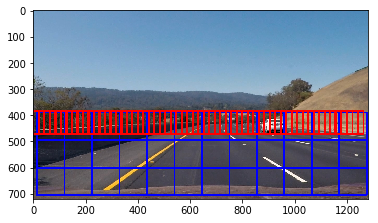

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows1 = slide_window(image, x_start_stop=[15, None], y_start_stop=[390, 710], 
                    xy_window=(210, 210), xy_overlap=(0.5, 0.5))
                    
windows2 = slide_window(image, x_start_stop=[0, None], y_start_stop=[395, 720], 
                    xy_window=(182, 182), xy_overlap=(0.5, 0.5))
                    
windows3 = slide_window(image, x_start_stop=[15, None], y_start_stop=[375, 720], 
                    xy_window=(158, 158), xy_overlap=(0.5, 0.5))
                    
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 560], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=[370, 480], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

windows6 = slide_window(image, x_start_stop=[None, None], y_start_stop=[388, 480], 
                    xy_window=(93, 93), xy_overlap=(0.75, 0.75))

windows7 = slide_window(image, x_start_stop=[None, None], y_start_stop=[385, 480], 
                    xy_window=(86, 86), xy_overlap=(0.75, 0.75))

windows8 = slide_window(image, x_start_stop=[None, None], y_start_stop=[390, 480], 
                    xy_window=(112, 112), xy_overlap=(0.75, 0.75))

window_img = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
#window_img = draw_boxes(window_img, windows2, color=(0, 255, 0), thick=6)
#window_img = draw_boxes(window_img, windows3, color=(255, 0, 0), thick=6)
#window_img = draw_boxes(window_img, windows4, color=(255, 0, 0), thick=6)
#window_img = draw_boxes(window_img, windows5, color=(255, 0, 0), thick=6)
#window_img = draw_boxes(window_img, windows6, color=(255, 0, 0), thick=6)
window_img = draw_boxes(window_img, windows7, color=(255, 0, 0), thick=6)
window_img = draw_boxes(window_img, windows8, color=(255, 0, 0), thick=6)

windows = windows1+windows2+windows3+windows4+windows5+windows6+windows7+windows8
#window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)         
print("number of windows: "+ str(len(windows)))
plt.imshow(window_img)

[1]
[0]


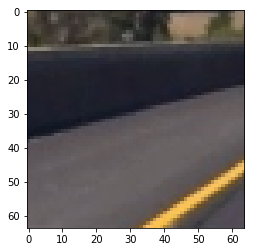

In [19]:
tt = preprocess(image, windows[143])
tt = tt/255
tt=tt.astype(np.float32)
plt.imshow(tt)

testfeatures = scaler.transform(extract_features_from_image(tt))
#print(testfeatures)
print(svc.predict([testfeatures]))
#print(extract_features_from_image(x_train[120]))
#print(extract_features_from_image(tt))
twofeatures = scaler.transform(extract_features_from_image(x_train[120]))
#print(twofeatures)
print(svc.predict([twofeatures]))

In [20]:
def classify_image(image, windows):
    rectangles = []
    for i in range(1,len(windows)):
        preprossed = preprocess(image, windows[i])
        preprossed = preprossed/255
        preprossed = preprossed.astype(np.float32)
        #plt.figure(figsize=(1,1))
        #plt.imshow(tt)

        testfeatures = scaler.transform(extract_features_from_image(preprossed))
    #    print(testfeatures)

    #testfeatures = features_from_img(imtest, windows)
        #print(svc.predict([testfeatures]))

        if (svc.predict([testfeatures]) == 0):
                rectangles.append(windows[i])
                #print(i)
    #pred = svc.predict_proba(testfeatures)[:,1]
    #print('The first 10 prediction results', pred[0:10])
    #print(rectangles)
    track_img = draw_boxes(image, rectangles, color=(0, 0, 255), thick=6)                             
    return track_img, rectangles
#plt.imshow(window_img)

In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def apply_heatmap(image, rectangles):
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    return heatmap_img
#    plt.figure(figsize=(10,10))
#    plt.imshow(heatmap_img, cmap='hot')

def extract_labels(heatmap_img):
    labels = label(heatmap_img)
    plt.figure(figsize=(10,10))
    plt.imshow(labels[0], cmap='gray')
    print(labels[1], 'cars found')

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

Done


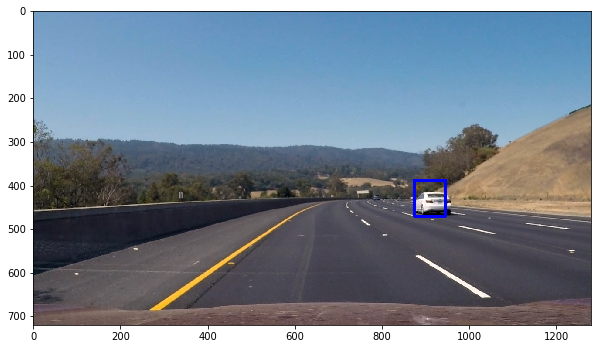

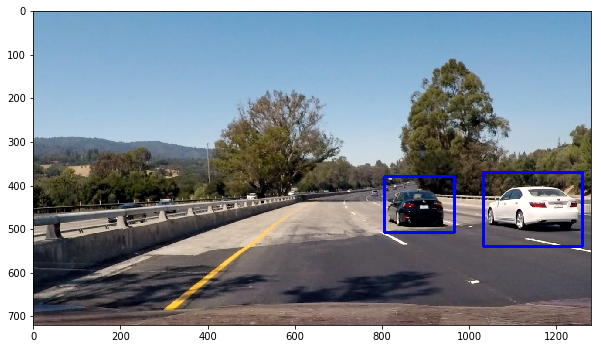

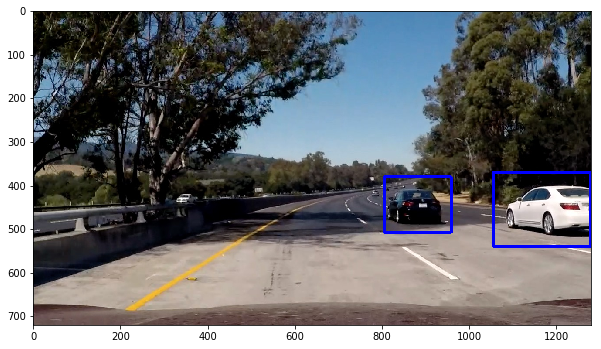

In [49]:
for i in range(3,6):
    image = cv2.imread('test'+str(i)+'.jpg')
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img, rectangles = classify_image(image, windows)
    plt.figure(figsize=(10,10))
    #plt.imshow(img)
    heat = apply_heatmap(image, rectangles)
    labels = label(heat)
    img, rects = draw_labeled_bboxes(image.copy(), labels)
    
    plt.imshow(img, cmap='gray')
    
    misc.imsave('test_with_bboxes_'+str(i)+'.jpg', img)
#kk = process_frame(image, True)
#plt.imshow(kk)
print('Done')

In [26]:

cnt=0
def process_frame(image, force = True):
    global cnt
    cnt = cnt +1
    if  (cnt%30 != 0) and (not force):
        return image
    img, rectangles = classify_image(image, windows)
    #return img
    heat = apply_heatmap(image, rectangles)
    labels = label(heat)
    img, rects = draw_labeled_bboxes(image.copy(), labels)
    return img


In [ ]:
#test_out_file = 'test_video_out.mp4'
#clip_test = VideoFileClip('test_video.mp4')
test_out_file = 'test_project_video.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_project_video.mp4
[MoviePy] Writing video test_project_video.mp4



 24%|██▍       | 307/1261 [16:28<51:12,  3.22s/it]


 48%|████▊     | 609/1261 [32:40<34:54,  3.21s/it]


 72%|███████▏  | 911/1261 [48:50<18:44,  3.21s/it]


 96%|█████████▌| 1206/1261 [1:04:38<02:56,  3.21s/it]


100%|█████████▉| 1260/1261 [1:07:32<00:03,  3.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project_video.mp4 

CPU times: user 1h 7min 28s, sys: 4.61 s, total: 1h 7min 32s
Wall time: 1h 7min 33s
